# Study quantization errors

Here we build a fake quantized model, very similar to what POT does, and observe how CPU plugin's output error will be.

In [10]:
from openvino.runtime import Core, Model, Tensor, PartialShape, Type, Shape
from openvino.runtime import opset8 as opset
from openvino.runtime.passes import Manager
import numpy as np
import ovhelper, os

device = "CPU"
core = Core()

def simplecnn(weight_value, bias_value):
    input_shape = [1, 3, 16, 16]
    param_node = opset.parameter(dtype = np.float32, shape=input_shape)

    input = opset.fake_quantize(param_node,[0.],[255.],[0.],[255.], 256)
    c_out = 1
    c_in = input_shape[1]
    padding_begin = padding_end = [0, 0]
    wvalue = opset.constant(np.ones([c_out,c_in,1,1], dtype=np.int8)*weight_value)
    weight = opset.convert(wvalue, np.float32) - opset.constant(np.zeros([1,1,1,1], dtype=np.float32))
    weight = weight * opset.constant(np.ones([1,1,1,1], dtype=np.float32) * (1/weight_value))
    conv = opset.convolution(input, weight, [1, 1], padding_begin, padding_end, [1, 1], name="conv1")
    bias = opset.constant(np.ones([c_out,1,1], dtype=np.float32)*bias_value)
    add = opset.add(conv, bias)

    model = Model([add], [param_node], 'simplecnn')
    return model

weight_value = 65
bias_value = 0.123456
model = simplecnn(weight_value, bias_value)


diff at (15,13): 757.2311401367188  vs  759.1234741210938
diff at (15,14): 758.2311401367188  vs  762.1234741210938
diff at (15,15): 759.2311401367188  vs  765.1234741210938


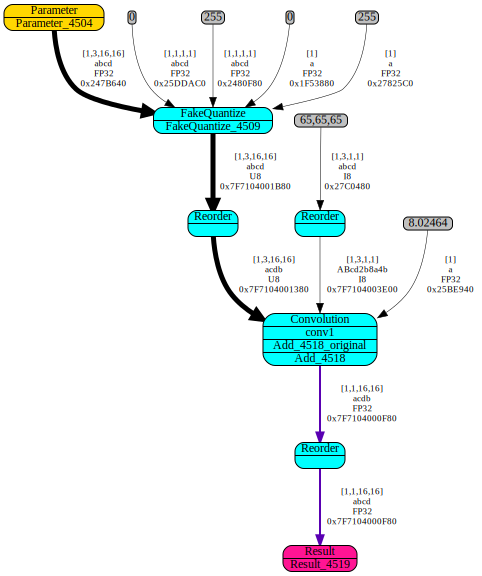

In [11]:
os.environ["OPT_LINENUM"] = str(999)
compiled_model_quant = core.compile_model(model, "CPU")

input0 = np.zeros([1, 3, 16, 16], dtype = np.float32)
expect0 = np.zeros([1, 1, 16, 16], dtype = np.float32)

for x in range(16):
    for y in range(16):
        rin = x + y*16
        input0[0,:,y,x] = rin
        expect0[0,0,y,x] = rin*3 + bias_value

outputs = compiled_model_quant.infer_new_request({0: input0})

out = outputs[compiled_model_quant.output(0)]

if np.allclose(out, expect0):
    print("All close")
else:
    for x in range(16):
        for y in range(16):
            if not np.allclose(out[0,0,y,x], expect0[0,0,y,x]):
                print("diff at ({},{}): {}  vs  {}".format(y, x, out[0,0,y,x], expect0[0,0,y,x]))

graph, data = compiled_model_quant.get_runtime_model().visualize()
graph

In [12]:
for base, arrs in data.items():
    print("0x{:X}".format(base))
    for a in arrs:
        print(a.shape, a.dtype)
        print(a)

0x247B640
(1, 3, 16, 16) float32
[[[[1.6470499e-37 0.0000000e+00 1.6829680e-37 0.0000000e+00
    0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
    1.5554413e-43 1.5414283e-43 1.2751816e-43 4.7644148e-44
    1.1070258e-43 1.1210388e-43 1.1770907e-43 1.3312335e-43]
   [1.0649868e-43 1.0229479e-43 1.0930128e-43 9.6689594e-44
    1.0930128e-43 1.1911037e-43 1.0789998e-43 4.7644148e-44
    1.3032076e-43 4.4841551e-44 8.5479206e-44 4.4841551e-44
    1.6114932e-43 1.6255062e-43 1.5974802e-43 5.6051939e-44]
   [7.9874012e-44 7.9874012e-44 7.9874012e-44 5.7453237e-44
    1.4012985e-44 1.3872855e-43 1.5554413e-43 1.5274153e-43
    1.5694543e-43 1.4713634e-43 1.5134023e-43 1.4153114e-43
    1.4012985e-43 1.3312335e-43 1.5274153e-43 1.5554413e-43]
   [1.4012985e-43 1.4153114e-43 1.5134023e-43 1.3312335e-43
    1.5834673e-43 1.6395192e-43 1.3592595e-43 1.5414283e-43
    1.6255062e-43 4.4841551e-44 8.5479206e-44 4.4841551e-44
    1.3872855e-43 1.5554413e-43 1.5974802e-43 1.4153114e-43]
   